# 테슬라 종가예측 +포트폴리오 수익률
2021~2022년의 테슬라 관련 트윗 (Kaggle), Yahoo Finance의 지표, CNN Fear&Greed Index를 활용한 테슬라 종가 예측

# 테슬라 관련 트윗 감성분석

In [1]:
import pandas as pd

tweets_df = pd.read_csv('stock_tweets.csv')
print(tweets_df.head())

tweets_df = tweets_df.dropna(subset=['Tweet'])
tweets_df = tweets_df[tweets_df['Tweet'].str.strip() != '']

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  


In [2]:
!pip install contractions
# 트윗 전리리

In [3]:
import re
import contractions

def preprocess_text(text):
    text = text.lower()

    # URL, 멘션, 해시태그 제거
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[@#]\w+", " ", text)
    
    # 영어 축약어 복원
    text = contractions.fix(text)
    
    # 특수문자/이모지 제거, HTML 엔티티/금융약어 치환
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'&amp', 'and ', text)
    text = re.sub(r'&gt', ' greater than ', text)
    text = text.replace('%', ' percent')
    text = re.sub(r'p&f', 'point and figure', text)
    text = re.sub(r's&p', 'SP500', text)
    text = re.sub(r'q&a', 'question and answer', text)
    text = re.sub(r'b/c', ' because ', text)
    text = re.sub(r'b/o', ' break out ', text)
    text = re.sub(r'p/e', 'pe ratio', text)

    # 종목코드
    text = re.sub(r'\$[a-zA-Z]+', 'stock', text, flags=re.IGNORECASE)
    
    # 앞뒤 공백 정리
    text = text.strip()
    
    return text

In [4]:
all_tweets = pd.read_csv('stock_tweets.csv')

In [5]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [6]:
(all_tweets["Stock Name"].unique())

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [7]:
stock_name = 'TSLA'

In [8]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)

(37422, 4)


In [9]:
sent_df = df.copy()
df.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [10]:
!pip install transformers torch tqdm

# BERT 기반 감성분석 모델

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 트위터 감정분석 특화 모델 
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
def get_sentiment(text):
    # 토큰화
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    scores = outputs[0][0].softmax(dim=0)
    labels = ['negative', 'neutral', 'positive']
    return labels[scores.argmax().item()], float(scores.max())

In [17]:
from tqdm import tqdm


tqdm.pandas()
sent_df['sentiment'], sent_df['sentiment_score'] = zip(*sent_df['Tweet'].progress_apply(get_sentiment))

100%|██████████| 37422/37422 [3:05:41<00:00,  3.36it/s]      


In [12]:
sent_df.head() 

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [13]:
df_sentiment = pd.read_csv('tsla_sentiment.csv')

# 감성분석  EDA

In [14]:
df_sentiment

,Date,Tweet,Stock Name,Company Name,sentiment,sentiment_score
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",negative,0.682188
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",neutral,0.675300
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",neutral,0.890414
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",negative,0.910034
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",negative,0.944234
...,...,...,...,...,...,...
37417,2021-09-30 02:52:38+00:00,Playing in the dirt and #chasingsunsets\n@tesl...,TSLA,"Tesla, Inc.",neutral,0.787863
37418,2021-09-30 02:40:26+00:00,I agree with @freshjiva that $TSLA ‘s EV busin...,TSLA,"Tesla, Inc.",neutral,0.745458
37419,2021-09-30 01:59:02+00:00,Hold. On. Tight. $TSLA,TSLA,"Tesla, Inc.",neutral,0.699712
37420,2021-09-30 01:38:26+00:00,Get ready for a $TSLA _ _ _ _ _ _ Q3 delivery...,TSLA,"Tesla, Inc.",neutral,0.769039


In [15]:
print(df_sentiment['sentiment'].value_counts())

sentiment
neutral     15946
positive    14945
negative     6531
Name: count, dtype: int64


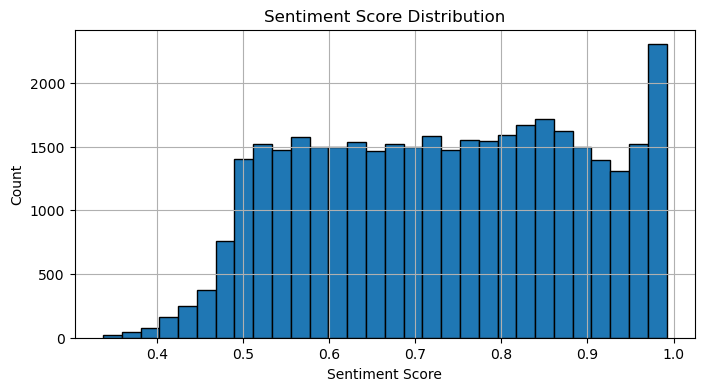

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(df_sentiment['sentiment_score'], bins=30, edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

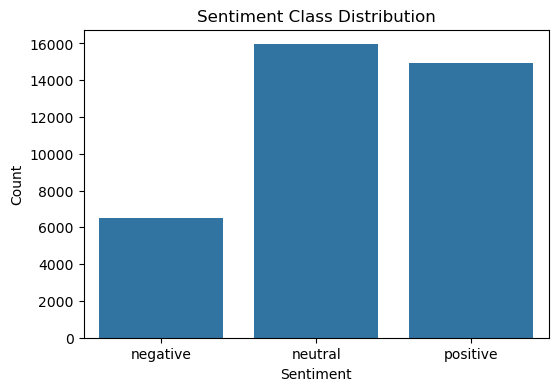

In [17]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df_sentiment, order=['negative', 'neutral', 'positive'])
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [18]:
print(df_sentiment.groupby('sentiment')['sentiment_score'].describe())

             count      mean       std       min       25%       50%  \
sentiment                                                              
negative    6531.0  0.695051  0.139709  0.339552  0.577957  0.696943   
neutral    15946.0  0.681245  0.129636  0.337167  0.572074  0.681010   
positive   14945.0  0.806737  0.158087  0.340310  0.680100  0.851893   

                75%       max  
sentiment                      
negative   0.814567  0.956971  
neutral    0.790839  0.954977  
positive   0.949481  0.991976  


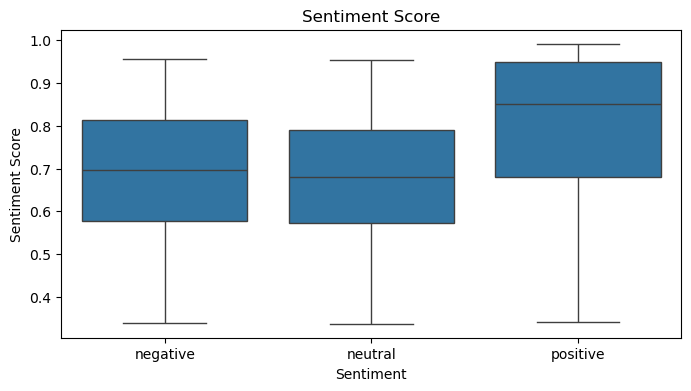

In [19]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='sentiment', y='sentiment_score', data=df_sentiment, order=['negative', 'neutral', 'positive'])
plt.title('Sentiment Score')
plt.xlabel('Sentiment')
plt.ylabel('Sentiment Score')
plt.show()

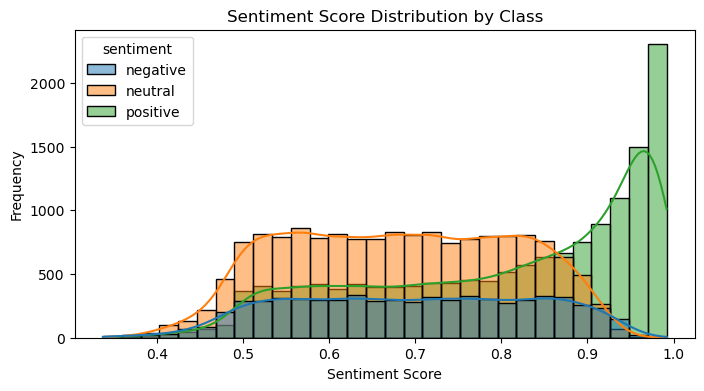

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(data=df_sentiment, x='sentiment_score', hue='sentiment', bins=30, kde=True)
plt.title("Sentiment Score Distribution by Class")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [21]:
# 이 데이터셋에서는, ‘확실히 긍정’인 트윗만 positive로 분류되고, 
# 나머지는 중립/부정에 퍼져 있다. 중립 트윗의 신뢰도가 대체로 중간쯤에 머물러, 분석할 때 중립이 많은 경우 내용 확인이 필요하다.

# 일별 Sentiment Score 계산 
트위터 데이터에 대해 사전학습된 감성분석 모델을 적용하여, 각 트윗마다 긍정(positive), 중립(neutral), 부정(negative) 중
하나의 감성 레이블과 해당 레이블에 대한 신뢰도(확률값)를 산출하였다. 이후, 각 감성 레이블을 숫자값(긍정은 +1, 중립은 0, 부정은 -1)으로 변환한 뒤, 
해당 트윗의 신뢰도 점수와 곱하여 weighted sentiment를 계산하였다.각 날짜별로 집계하여,동일 날짜의 감성 신뢰도 점수(확률) 총합으로 나누는 방식

In [23]:
# 감성 라벨을 숫자값으로 변환
sent_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df_sentiment['sentiment_num'] = df_sentiment['sentiment'].map(sent_map)

# 2. 'sentiment_score'와 곱해서 weighted_sentiment 생성
df_sentiment['weighted_sentiment'] = df_sentiment['sentiment_num'] * df_sentiment['sentiment_score']

In [24]:
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], errors='coerce')

df_sentiment['date_only'] = df_sentiment['Date'].dt.date


df_sentiment['date_only'] = df_sentiment['Date'].dt.date

wsum = df_sentiment.groupby('date_only')['weighted_sentiment'].sum()
ssum = df_sentiment.groupby('date_only')['sentiment_score'].sum()
daily_sentiment_weighted = (wsum / ssum).reset_index(name='daily_sentiment_index_weighted')

print(daily_sentiment_weighted.head(10))

    date_only  daily_sentiment_index_weighted
0  2021-09-30                        0.148694
1  2021-10-01                        0.323274
2  2021-10-02                        0.657869
3  2021-10-03                        0.445045
4  2021-10-04                        0.162012
5  2021-10-05                        0.195401
6  2021-10-06                        0.229157
7  2021-10-07                        0.438213
8  2021-10-08                        0.277815
9  2021-10-09                        0.603735


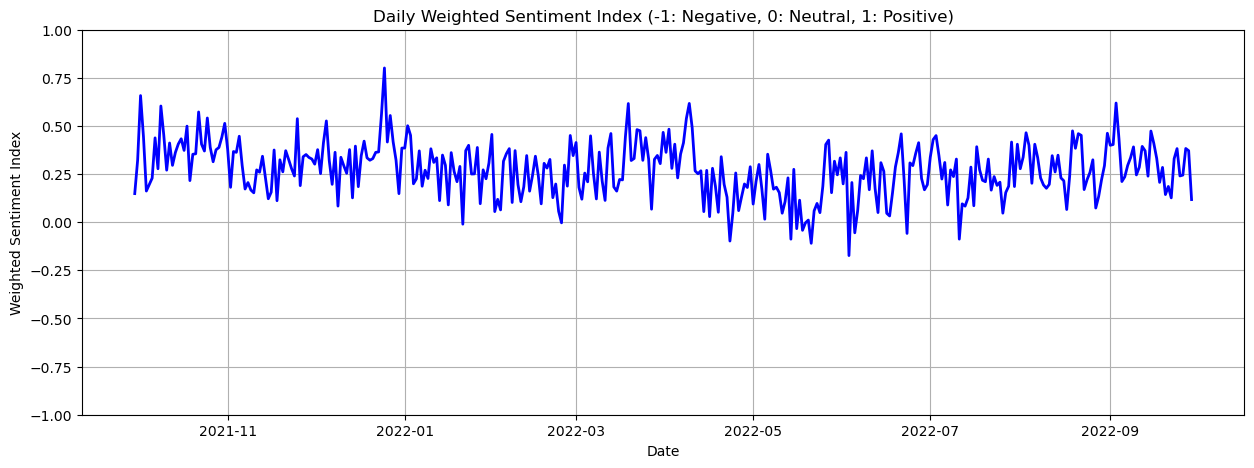

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(daily_sentiment_weighted['date_only'], daily_sentiment_weighted['daily_sentiment_index_weighted'], color='blue', linewidth=2)
plt.title('Daily Weighted Sentiment Index (-1: Negative, 0: Neutral, 1: Positive)')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment Index')
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

# Yahoo Finance, CNN F&G Index 

In [26]:
stock_df = pd.read_csv('stock_yfinance_CNN_data.csv')

In [27]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Fear Greed Index,Rating
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,10,Extreme Fear
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,18,Extreme Fear
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,10,Extreme Fear
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,19,Extreme Fear
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,20,Extreme Fear
...,...,...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV,22,Extreme Fear
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV,18,Extreme Fear
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV,17,Extreme Fear
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV,17,Extreme Fear


In [28]:
tsla_df = stock_df[stock_df['Stock Name'] == 'TSLA']
print(tsla_df.shape)   
print(tsla_df.head())  

(252, 10)
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  Fear Greed Index        Rating  
0  53868000       TSLA                10  Extreme Fear  
1  51094200       TSLA                18  Extreme Fear  
2  91449900       TSLA                10  Extreme Fear  
3  55297800       TSLA                19  Extreme Fear  
4  43898400       TSLA                20  Extreme Fear  


In [29]:
tsla_df = stock_df[stock_df['Stock Name'] == 'TSLA'].copy()
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'], errors='coerce')

In [30]:
print(tsla_df.isnull().sum())

Date                0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Stock Name          0
Fear Greed Index    0
Rating              0
dtype: int64


In [31]:
print(tsla_df.dtypes)

Date                datetime64[ns]
Open                       float64
High                       float64
Low                        float64
Close                      float64
Adj Close                  float64
Volume                       int64
Stock Name                  object
Fear Greed Index             int64
Rating                      object
dtype: object


In [32]:
tsla_df = tsla_df.sort_values('Date')

In [33]:
# tsla_df의 Date 컬럼을 일 단위로 맞추기
tsla_df['date_only'] = pd.to_datetime(tsla_df['Date']).dt.date

In [34]:
# 'date_only'를 기준으로 병합
merged_df = pd.merge(tsla_df, daily_sentiment_weighted, on='date_only', how='left')

In [35]:
print(merged_df.head())
print(merged_df.columns)

        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1 2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2 2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3 2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4 2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  Fear Greed Index        Rating   date_only  \
0  53868000       TSLA                10  Extreme Fear  2021-09-30   
1  51094200       TSLA                18  Extreme Fear  2021-10-01   
2  91449900       TSLA                10  Extreme Fear  2021-10-04   
3  55297800       TSLA                19  Extreme Fear  2021-10-05   
4  43898400       TSLA                20  Extreme Fear  2021-10-06   

   daily_sentiment_index_weighted  
0                        0.148694  
1                        0.323274  
2             

In [36]:
# Close 컬럼을 0~100 사이로 정규화
tsla_min = merged_df['Close'].min()
tsla_max = merged_df['Close'].max()
merged_df['close_0_100'] = (merged_df['Close'] - tsla_min) / (tsla_max - tsla_min) * 100

In [37]:
# 예시: daily_sentiment_index_weighted를 0~100 스케일로 변환
merged_df['sentiment_index_0_100'] = ((merged_df['daily_sentiment_index_weighted'] + 1) / 2) * 100

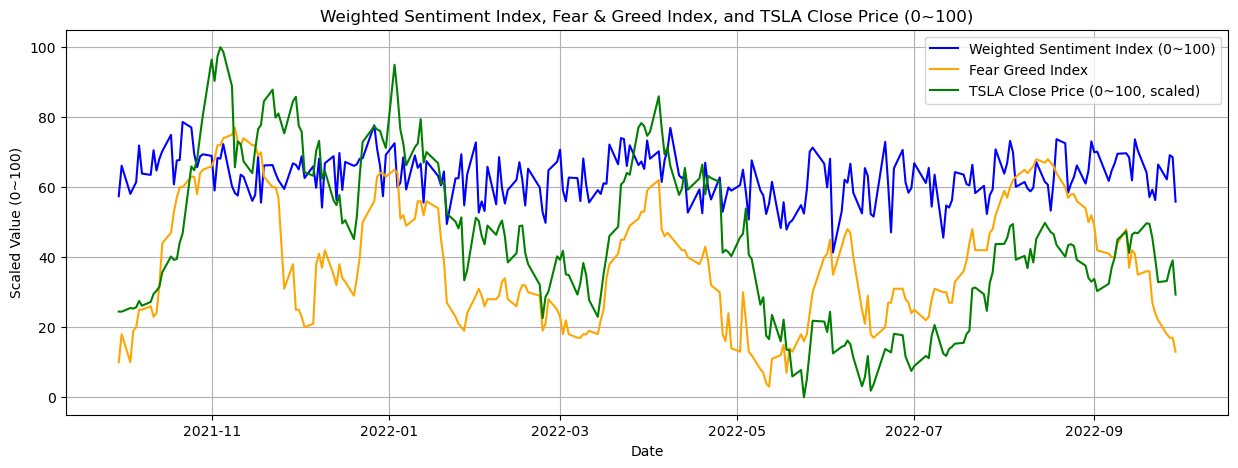

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(merged_df['date_only'], merged_df['sentiment_index_0_100'], label='Weighted Sentiment Index (0~100)', color='blue')
plt.plot(merged_df['date_only'], merged_df['Fear Greed Index'], label='Fear Greed Index', color='orange')
plt.plot(merged_df['date_only'], merged_df['close_0_100'], label='TSLA Close Price (0~100, scaled)', color='green')
plt.title('Weighted Sentiment Index, Fear & Greed Index, and TSLA Close Price (0~100)')
plt.xlabel('Date')
plt.ylabel('Scaled Value (0~100)')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# 상관관계 분석
cols = ['sentiment_index_0_100', 'Fear Greed Index', 'close_0_100']
corr_matrix = merged_df[cols].corr()
print(corr_matrix)

                       sentiment_index_0_100  Fear Greed Index  close_0_100
sentiment_index_0_100               1.000000          0.349631     0.368698
Fear Greed Index                    0.349631          1.000000     0.611578
close_0_100                         0.368698          0.611578     1.000000


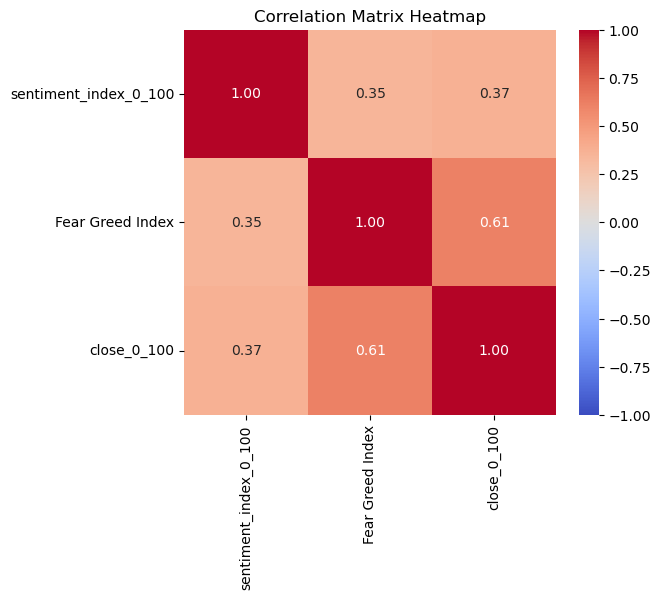

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 분석할 컬럼만 추출 (NaN은 자동제외)
cols = ['sentiment_index_0_100', 'Fear Greed Index', 'close_0_100']
corr_matrix = merged_df[cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# 피처간의 상관관계 변화를 시게열적인 관점에서 시각화

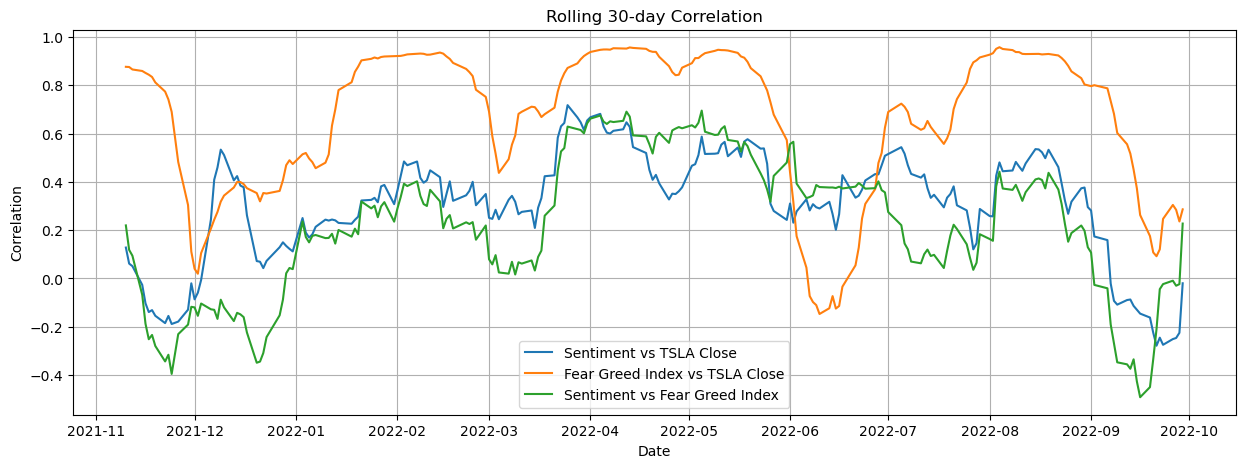

In [41]:
window = 30  # 30일 롤링 윈도우

# 예: TSLA 가격과 트위터 감성지수의 rolling correlation
rolling_corr_sent_close = merged_df['sentiment_index_0_100'].rolling(window).corr(merged_df['close_0_100'])
rolling_corr_fear_close = merged_df['Fear Greed Index'].rolling(window).corr(merged_df['close_0_100'])
rolling_corr_sent_fear = merged_df['sentiment_index_0_100'].rolling(window).corr(merged_df['Fear Greed Index'])

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(merged_df['date_only'], rolling_corr_sent_close, label='Sentiment vs TSLA Close')
plt.plot(merged_df['date_only'], rolling_corr_fear_close, label='Fear Greed Index vs TSLA Close')
plt.plot(merged_df['date_only'], rolling_corr_sent_fear, label='Sentiment vs Fear Greed Index')
plt.title(f'Rolling {window}-day Correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# "Fear & Greed Index는 TSLA 주가와 강한 연관성을 보이는 반면,
# 감성지수는 그보다는 약한 수준의 연관성을 가지고 구간에 따라 심리와 가격이 반대되는 시점이 존재한다.

In [42]:
stock_df = pd.read_csv('stock_yfinance_CNN_data.csv')

In [43]:
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Fear Greed Index,Rating
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,10,Extreme Fear
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,18,Extreme Fear
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,10,Extreme Fear
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,19,Extreme Fear
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,20,Extreme Fear
...,...,...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV,22,Extreme Fear
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV,18,Extreme Fear
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV,17,Extreme Fear
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV,17,Extreme Fear


In [44]:
tsla_df = stock_df[stock_df['Stock Name'] == 'TSLA']
print(tsla_df.shape)   
print(tsla_df.head())  

(252, 10)
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  Fear Greed Index        Rating  
0  53868000       TSLA                10  Extreme Fear  
1  51094200       TSLA                18  Extreme Fear  
2  91449900       TSLA                10  Extreme Fear  
3  55297800       TSLA                19  Extreme Fear  
4  43898400       TSLA                20  Extreme Fear  


In [45]:
tsla_df = stock_df[stock_df['Stock Name'] == 'TSLA'].copy()
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'], errors='coerce')

In [46]:
print(tsla_df.isnull().sum())

Date                0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
Stock Name          0
Fear Greed Index    0
Rating              0
dtype: int64


In [47]:
print(tsla_df.dtypes)

Date                datetime64[ns]
Open                       float64
High                       float64
Low                        float64
Close                      float64
Adj Close                  float64
Volume                       int64
Stock Name                  object
Fear Greed Index             int64
Rating                      object
dtype: object


In [52]:
tsla_df = tsla_df.sort_values('Date')

In [48]:
tsla_df['date_only'] = pd.to_datetime(tsla_df['Date']).dt.date

In [49]:
merged_df

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Fear Greed Index,Rating,date_only,daily_sentiment_index_weighted,close_0_100,sentiment_index_0_100
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,10,Extreme Fear,2021-09-30,0.148694,24.481932,57.434685
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,18,Extreme Fear,2021-10-01,0.323274,24.438723,66.163724
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,10,Extreme Fear,2021-10-04,0.162012,25.487331,58.100593
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,19,Extreme Fear,2021-10-05,0.195401,25.331109,59.770030
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,20,Extreme Fear,2021-10-06,0.229157,25.690063,61.457830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,TSLA,22,Extreme Fear,2022-09-23,0.329824,32.875770,66.491217
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,TSLA,18,Extreme Fear,2022-09-26,0.244789,33.214793,62.239439
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,TSLA,17,Extreme Fear,2022-09-27,0.383013,36.669712,69.150671
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,TSLA,17,Extreme Fear,2022-09-28,0.371451,39.097629,68.572568


In [50]:
cols_to_drop = ['date_only', 'Adj Close', 'close_0_100', 'sentiment_index_0_100']
merged_df = merged_df.drop(columns=cols_to_drop)

In [51]:
merged_df

,Date,Open,High,Low,Close,Volume,Stock Name,Fear Greed Index,Rating,daily_sentiment_index_weighted
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000,TSLA,10,Extreme Fear,0.148694
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200,TSLA,18,Extreme Fear,0.323274
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900,TSLA,10,Extreme Fear,0.162012
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800,TSLA,19,Extreme Fear,0.195401
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400,TSLA,20,Extreme Fear,0.229157
...,...,...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,63748400,TSLA,22,Extreme Fear,0.329824
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,58076900,TSLA,18,Extreme Fear,0.244789
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,61925200,TSLA,17,Extreme Fear,0.383013
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,54664800,TSLA,17,Extreme Fear,0.371451


In [56]:
# 기존 컬럼들을 활용해 4개의 파생변수 생성해 최종 데이터셋 구성

In [57]:
import pandas as pd

merged_df = pd.read_csv('tsla_merged_df.csv')

# 가격 20일 이동평균 Z-score
merged_df['MA20'] = merged_df['Close'].rolling(20).mean()
merged_df['MA20_STD'] = merged_df['Close'].rolling(20).std()
merged_df['Zscore_MA20'] = (merged_df['Close'] - merged_df['MA20']) / merged_df['MA20_STD']

# 5일 모멘텀
merged_df['Momentum_5'] = merged_df['Close'] / merged_df['Close'].shift(5) - 1

# 감성지수 5일 이동평균
merged_df['Sentiment_MA5'] = merged_df['daily_sentiment_index_weighted'].rolling(5).mean()

# F&G Index 5일 이동평균
merged_df['FG_Index_MA5'] = merged_df['Fear Greed Index'].rolling(5).mean()

# 최종 데이터셋 
final_cols = [
    'Date',                
    'Close',                # 타깃
    'Zscore_MA20',
    'Momentum_5',
    'Sentiment_MA5',
    'FG_Index_MA5',
]
final_df = merged_df[final_cols].copy()

final_df = final_df.dropna().reset_index(drop=True)

final_df.to_csv('tsla_final_features.csv', index=False, encoding='utf-8-sig')

In [58]:
final_df

,Date,Close,Zscore_MA20,Momentum_5,Sentiment_MA5,FG_Index_MA5
0,2021-10-27,345.953339,2.163750,0.198729,0.434631,60.8
1,2021-10-28,359.013336,2.153395,0.204743,0.438787,61.6
2,2021-10-29,371.333344,2.101121,0.224607,0.401884,62.6
3,2021-11-01,402.863342,2.359612,0.179273,0.369376,63.2
4,2021-11-02,390.666656,1.790930,0.150791,0.327805,64.2
...,...,...,...,...,...,...
228,2022-09-23,275.329987,-1.184509,-0.092369,0.214119,29.0
229,2022-09-26,276.010010,-1.051355,-0.106966,0.206125,25.4
230,2022-09-27,282.940002,-0.516706,-0.083536,0.253986,21.6
231,2022-09-28,287.809998,-0.190963,-0.043185,0.291125,19.6


# LSTM 활용한 종가 예측& 포트폴리오 수익률

In [64]:
import pandas as pd
import numpy as np

df = pd.read_csv('tsla_final_features.csv', parse_dates=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

feature_cols = ['Zscore_MA20', 'Momentum_5', 'Sentiment_MA5', 'FG_Index_MA5']
target_col = 'Close'

X = df[feature_cols].values
y = df[target_col].values

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_X = StandardScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

In [65]:
# LSTM 입력용 시퀀스 생성
def create_sequences(X, y, seq_length=20):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_lstm, y_lstm = create_sequences(X_scaled, y_scaled, SEQ_LEN)

In [66]:
# (시계열 분할)
train_size = int(len(X_lstm) * 0.8)
X_train, X_test = X_lstm[:train_size], X_lstm[train_size:]
y_train, y_test = y_lstm[:train_size], y_lstm[train_size:]

In [67]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(SEQ_LEN, X_lstm.shape[2]), return_sequences=False),
    keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.1, verbose=1)


Epoch 1/20


C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.2187 - val_loss: 0.0150
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0799 - val_loss: 0.0228
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0272 - val_loss: 0.0275
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0194 - val_loss: 0.0305
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0114 - val_loss: 0.0347
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0102 - val_loss: 0.0401
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0098 - val_loss: 0.0414
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0074 - val_loss: 0.0341
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0077 - val_loss: 0.0349
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0069 - val_loss: 0.0337
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0066 - val_loss: 0.0353
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0071 - val_l

In [72]:
y_pred_scaled = model.predict(X_test)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_true = scaler_y.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred))

print(f"LSTM 종가 예측 MAE : {mae:.4f}")
print(f"LSTM 종가 예측 RMSE: {rmse:.4f}")

LSTM 종가 예측 MAE : 44.5700
LSTM 종가 예측 RMSE: 51.9645


In [75]:
# 투자 전략: 예측값 > 전날 실제값 → 매수, 아니면 노포지션
buy_signal = y_pred.flatten() > np.roll(y_test_true.flatten(), 1)
buy_signal[0] = False  # 첫날은 매매 X

# 실제 수익률 계산
close_test = y_test_true.flatten()
returns = np.zeros_like(close_test)

for i in range(1, len(close_test)):
    if buy_signal[i-1]:
        # 어제 매수하고 난 뒤 오늘 수익률
        returns[i] = (close_test[i] - close_test[i-1]) / close_test[i-1]
    else:
        returns[i] = 0

cumulative_returns = np.cumprod(1 + returns) - 1
print("최종 누적수익률: {:.2%}".format(cumulative_returns[-1]))

최종 누적수익률: -9.59%


C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

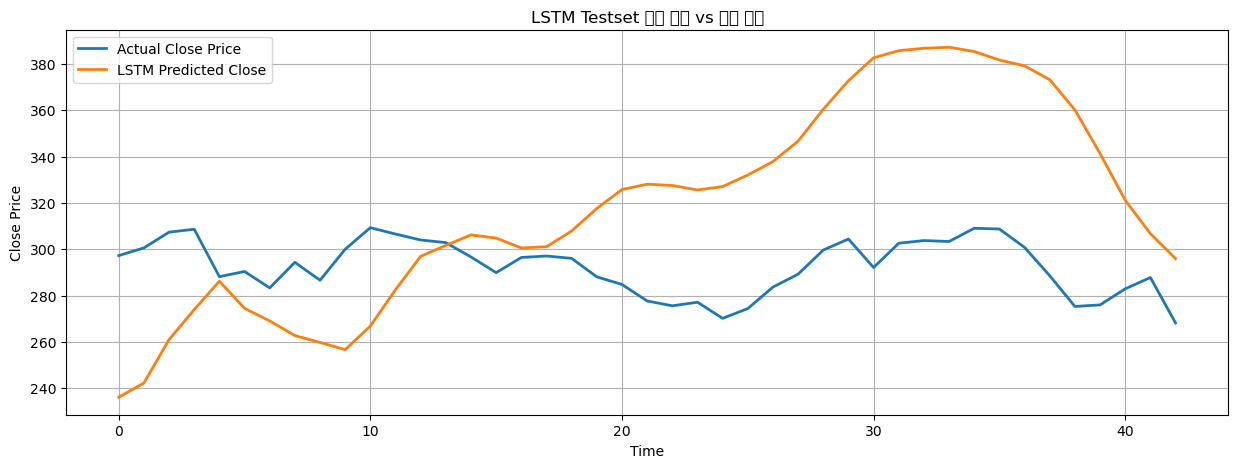

In [76]:
# 실제값 vs 예측값 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(y_test_true, label='Actual Close Price', linewidth=2)
plt.plot(y_pred, label='LSTM Predicted Close', linewidth=2)
plt.title('LSTM Testset 종가 예측 vs 실제 종가')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 강화학습 (A2C 알고리즘)

In [77]:
!pip install stable-baselines3[extra] gym

In [79]:
import gym
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, prices, features):
        super().__init__()
        self.prices = prices
        self.features = features
        self.action_space = gym.spaces.Discrete(3)  # 0: 관망, 1: 매수, 2: 매도
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],))
        self.reset()
    
    def reset(self):
        self.current_step = 0
        self.position = 0
        self.entry_price = 0
        return self.features[self.current_step]
    
    def step(self, action):
        reward = 0
        price = self.prices[self.current_step]
        done = False

        # 진입/청산 전략
        if self.position == 0:
            if action == 1:  # 롱 진입
                self.position = 1
                self.entry_price = price
            elif action == 2:  # 숏 진입
                self.position = -1
                self.entry_price = price
        else:
            if (self.position == 1 and action == 2) or (self.position == -1 and action == 1):
                reward = (price - self.entry_price) * self.position
                self.position = 0
                self.entry_price = 0

        self.current_step += 1
        if self.current_step >= len(self.prices) - 1:
            done = True
        next_state = self.features[self.current_step]
        return next_state, reward, done, {}

In [80]:
import tensorflow as tf
from tensorflow import keras

# X_lstm: (샘플수, seq_len, feature_dim)
lstm_encoder = keras.models.Sequential([
    keras.layers.LSTM(32, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=False)
])
state_features = lstm_encoder.predict(X_lstm)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [81]:
!pip install shimmy>=2.0

In [82]:
from stable_baselines3 import A2C

env = TradingEnv(prices=close_test, features=state_features)
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# 평가
obs = env.reset()
done = False
rewards = []
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
print(f"총 누적수익(A2C): {np.sum(rewards):.2f}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\User\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 42       |
|    ep_rew_mean        | 0.899    |
| time/                 |          |
|    fps                | 413      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.05    |
|    explained_variance | 0.104    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -3.37    |
|    value_loss         | 16.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 42       |
|    ep_rew_mean        | -3.49    |
| time/                 |          |
|    fps                | 369      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 1000     |
| train/                |          |
|